In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def evall1l2term(wp, d, Jd, Jdd, l1, l2, alpha):
    """
    Evaluate and compute derivatives for combined l1/l2 norm penalty.
    loss = (0.5 * l2 * d^2) + (l1 * sqrt(alpha + d^2))
    Args:
        wp: T x D matrix with weights for each dimension and time step.
        d: T x D states to evaluate norm on.
        Jd: T x D x Dx Jacobian - derivative of d with respect to state.
        Jdd: T x D x Dx x Dx Jacobian - 2nd derivative of d with respect
            to state.
        l1: l1 loss weight.
        l2: l2 loss weight.
        alpha: Constant added in square root.
    """
    # Get trajectory length.
    T, _ = d.shape

    # Compute scaled quantities.
    sqrtwp = np.sqrt(wp)
    dsclsq = d * sqrtwp
    dscl = d * wp
    dscls = d * (wp ** 2)

    # Compute total cost.
    l = 0.5 * np.sum(dsclsq ** 2, axis=1) * l2 + \
            np.sqrt(alpha + np.sum(dscl ** 2, axis=1)) * l1

    # First order derivative terms.
    d1 = dscl * l2 + (
        dscls / np.sqrt(alpha + np.sum(dscl ** 2, axis=1, keepdims=True)) * l1
    )
    lx = np.sum(Jd * np.expand_dims(d1, axis=2), axis=1)

    # Second order terms.
    psq = np.expand_dims(
        np.sqrt(alpha + np.sum(dscl ** 2, axis=1, keepdims=True)), axis=1
    )
    d2 = l1 * (
        (np.expand_dims(np.eye(wp.shape[1]), axis=0) *
         (np.expand_dims(wp ** 2, axis=1) / psq)) -
        ((np.expand_dims(dscls, axis=1) *
          np.expand_dims(dscls, axis=2)) / psq ** 3)
    )
    d2 += l2 * (
        np.expand_dims(wp, axis=2) * np.tile(np.eye(wp.shape[1]), [T, 1, 1])
    )

    d1_expand = np.expand_dims(np.expand_dims(d1, axis=-1), axis=-1)
    sec = np.sum(d1_expand * Jdd, axis=1)

    Jd_expand_1 = np.expand_dims(np.expand_dims(Jd, axis=2), axis=4)
    Jd_expand_2 = np.expand_dims(np.expand_dims(Jd, axis=1), axis=3)
    d2_expand = np.expand_dims(np.expand_dims(d2, axis=-1), axis=-1)
    lxx = np.sum(np.sum(Jd_expand_1 * Jd_expand_2 * d2_expand, axis=1), axis=1)

    lxx += 0.5 * sec + 0.5 * np.transpose(sec, [0, 2, 1])

    return l, lx, lxx

In [107]:
def state_difference_cost(x, tgt, l1=1, l2=1, alpha=1e-5):
#     print('---')
#     print(x)
    T, dim_sensor = x.shape

    wp = np.ones_like(x)
    # Compute state penalty.
    dist = (tgt - x)

    # Jd = [Jtgt Jx]
    Jd = np.c_[np.eye(dim_sensor), -np.eye(dim_sensor)]

    # Evaluate penalty term.
    l, ls, lss = evall1l2term(
        wp, dist, np.tile(Jd, [T, 1, 1]),
        np.zeros((T, dim_sensor, 2*dim_sensor, 2*dim_sensor)),
        l1, l2, alpha)
#     print(l)
    return l, ls

In [81]:
def safe_distance_cost(x, tgt, safe_dist, inside_cost=1.0, outside_cost=0):
    diff = x - tgt
    diff_abs = abs(diff)
    diff_norm = np.linalg.norm(diff_abs, axis=1, keepdims=True)
    safe_distance = np.linalg.norm(safe_dist, axis=1, keepdims=True)
    distance = diff_norm - safe_distance
    distance_abs = abs(distance)

    violation = distance < 0

    cost = (violation*inside_cost + ~violation*outside_cost)*distance_abs

    gradient = (violation*inside_cost + ~violation*outside_cost)\
                *distance/(distance_abs+1e-8)*diff/(diff_norm+1e-8)    
    return cost, gradient

In [213]:
def plot_all(X, Y, costs, tgt, obstacle, contour_levels=1000):
    fig, ax = plt.subplots(figsize=(16, 16))
    # ax.imshow(costs, cmap='hot', interpolation='nearest',
    #           extent=(x_lims[0], x_lims[1], y_lims[0], y_lims[1]))
    ax.contourf(X, Y, costs, contour_levels, alpha=1,cmap='jet')
    # ax.plot(tgt[0], tgt[1], 'o', markersize=7, markeredgewidth=1,markeredgecolor='w', markerfacecolor='None')
    # ax.plot(obstacle[0], obstacle[1], 'o', markersize=7, markeredgewidth=1,markeredgecolor='w', markerfacecolor='None')

    circle1 = plt.Circle(tgt, 0.02, color='white', alpha=0.2)
    circle2 = plt.Circle(obstacle, 0.05, color='black', alpha=0.2)
    ax.add_artist(circle1)
    ax.add_artist(circle2)

    plt.axis('equal')
    ax.axhline(color='black')
    ax.axvline(color='black')
    # ax.set_xlim(0,1)
    # ax.set_ylim(*y_lims)
    plt.show()

In [198]:
l1 = 1.5
l2 = 1.0
alpha = 1e-5

tgt = np.array([0.74, 0.26])
x = np.array([[0.75, 0.27], [0.74, 0.26], [0.73, 0.24]])

state_difference_cost(x, tgt, l1=l1, l2=l2, alpha=alpha)[0].flatten()

array([ 0.02183707,  0.00474342,  0.03412477])

In [201]:
tgt = np.array([0.74, 0.26])
obstacle = np.array([0.54, -0.43])

x_lims = [-0.5, 1]
y_lims = [-1, 1]
step = 0.01
contour_levels = 1000

X, Y = np.meshgrid(xs, ys)

costs = np.zeros_like(X)

all_xs, all_ys = costs.shape

xs = np.arange(x_lims[0], x_lims[1]+step, step)
ys = np.arange(y_lims[0], y_lims[1]+step, step)

Cost before 08/02


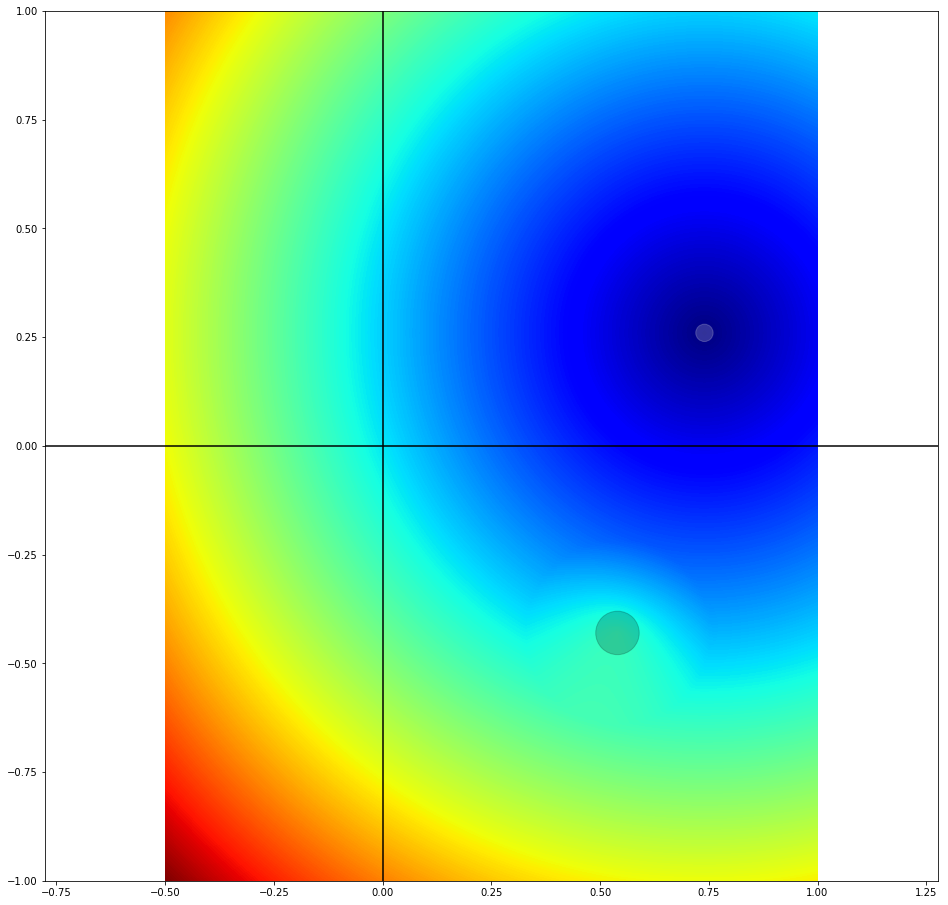

In [248]:
# COST BEFORE 08/02
# act: 1e-5, state: 5e-0, final_state:1e+3, safe:1e+1, final_safe:1e+3
w_state_diff = 5e-0
w_safe_dist = 1e+1
l1 = 1.5
l2 = 1.0
alpha = 1e-5
inside_cost = 1
outside_cost = 0
radius = 5
safe_x = 0.15#np.sqrt(radius**2/2)
safe_y = 0.15#np.sqrt(radius**2/2)
safe_dist = np.c_[safe_x, safe_y]

for ii in range(all_ys):
    costs[:,ii] = w_state_diff*state_difference_cost(np.c_[X[:,ii], Y[:,ii]], tgt,
                                                     l1=l1, l2=l2, alpha=alpha)[0].flatten()
    costs[:, ii] += w_safe_dist*safe_distance_cost(np.c_[X[:,ii], Y[:,ii]], obstacle, safe_dist=safe_dist,
                                                   inside_cost=inside_cost, outside_cost=outside_cost)[0].flatten()
    

print('Cost before 08/02')
plot_all(X, Y, costs, tgt, obstacle, contour_levels=contour_levels)

Cost 08/02


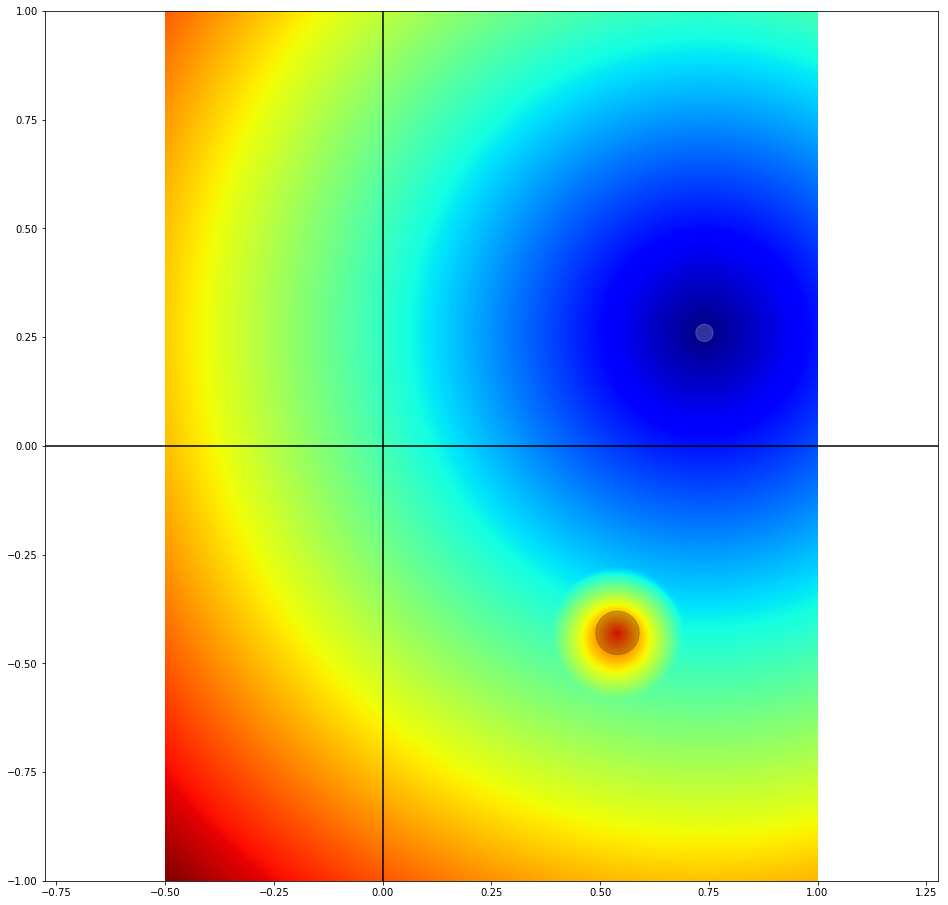

In [254]:
# COST 08/02
# act: 1e-5, state: 5e-0, final_state:1e+3, safe:1e+1, final_safe:1e+3
w_state_diff = 5e-0
w_safe_dist = 3e+1
l1 = 1.e0
l2 = 5.e-2
alpha = 1e-10
inside_cost = 1.
outside_cost = 0.
radius = 0.15
safe_x = np.sqrt(radius**2/2)
safe_y = np.sqrt(radius**2/2)
safe_dist = np.c_[safe_x, safe_y]

for ii in range(all_ys):
    costs[:,ii] = w_state_diff*state_difference_cost(np.c_[X[:,ii], Y[:,ii]], tgt,
                                                     l1=l1, l2=l2, alpha=alpha)[0].flatten()
    costs[:, ii] += w_safe_dist*safe_distance_cost(np.c_[X[:,ii], Y[:,ii]], obstacle, safe_dist=safe_dist,
                                                   inside_cost=inside_cost, outside_cost=outside_cost)[0].flatten()
    
print('Cost 08/02')
plot_all(X, Y, costs, tgt, obstacle, contour_levels=contour_levels)


Cost fcn


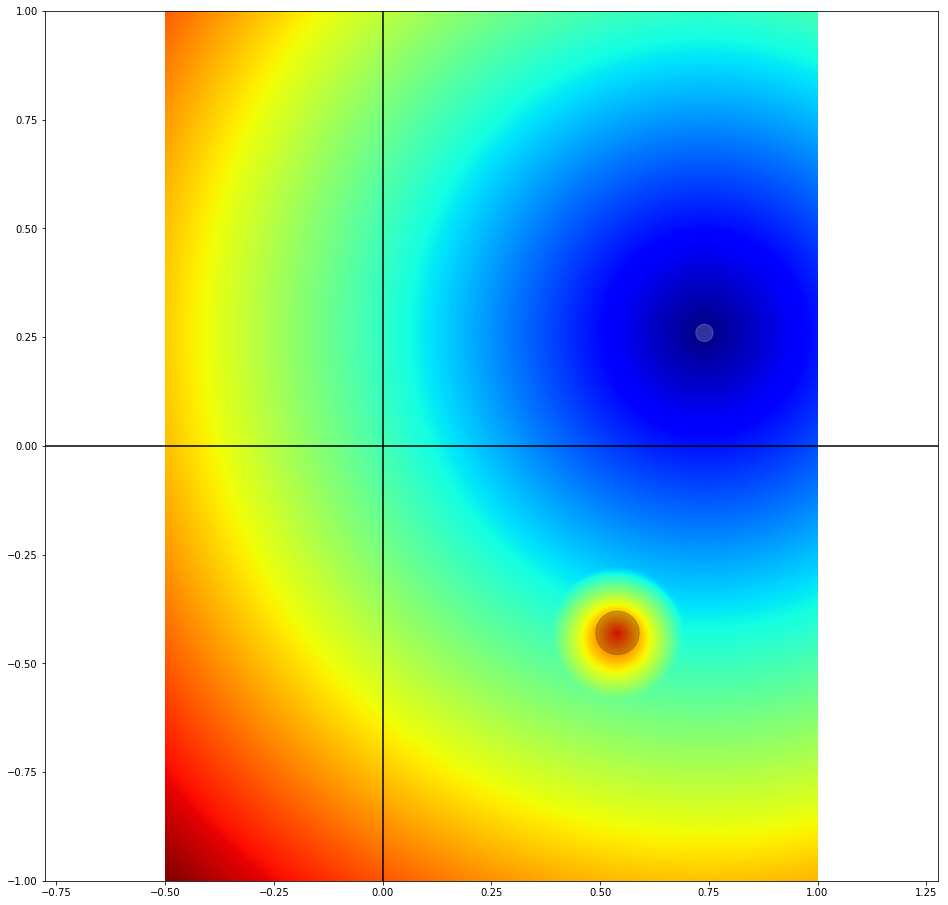

In [255]:
w_state_diff = 5e-0
w_safe_dist = 3e+1
l1 = 1e-0
l2 = 5.e-2
alpha = 1e-10
inside_cost = 1
outside_cost = 0
radius = 0.15
safe_x = np.sqrt(radius**2/2)
safe_y = np.sqrt(radius**2/2)
safe_dist = np.c_[safe_x, safe_y]

for ii in range(all_ys):
    costs[:,ii] = w_state_diff*state_difference_cost(np.c_[X[:,ii], Y[:,ii]], tgt,
                                                     l1=l1, l2=l2, alpha=alpha)[0].flatten()
    costs[:, ii] += w_safe_dist*safe_distance_cost(np.c_[X[:,ii], Y[:,ii]], obstacle, safe_dist=safe_dist,
                                                   inside_cost=inside_cost, outside_cost=outside_cost)[0].flatten()
    

print('Cost fcn')
plot_all(X, Y, costs, tgt, obstacle, contour_levels=contour_levels)